### Initialisation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

from generate_data import dataGenerator

from torch_parameters import *
from half_ellipsoid_predictor import *
from ellipsoid_predictor import *

from plot import *

seed_everything(42)

In [2]:
def generate_uniform_points_in_p_norm_ball(n, p):
    points = []
    while len(points) < n:
        # Générer un point uniformément dans le carré [-1, 1] x [-1, 1]
        x, y = np.random.uniform(-1, 1, 2)
        # Calculer la norme p du point
        norm_p = (abs(x)**p + abs(y)**p)**(1/p)
        # Vérifier si le point est dans la boule unité de la norme p
        if norm_p <= 1:
            points.append((x, y))
    return np.array(points)



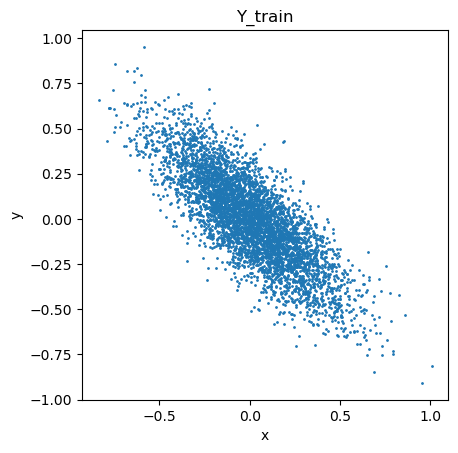

In [3]:
seed_everything(42)

n_train = 5000
n_test = 1000
n_calibration = 1000

k = 2
d = 2
pert = "gaussian"
covariance_matrix = np.array([[1., -0.8], [-0.8, 1.]])
data_generator = dataGenerator(d, k, pert, covariance_matrix = covariance_matrix)
y_train, y_test, y_calibration = data_generator.generate_perturbation_train_calibration_test(n_train, n_test, n_calibration)
y_train1 = y_train/4 
y_test1 = y_train1
y_calibration1 = y_train1

# Plot the data
plt.scatter(y_train1[:, 0], y_train1[:, 1], s=1)
plt.title(f'Y_train')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

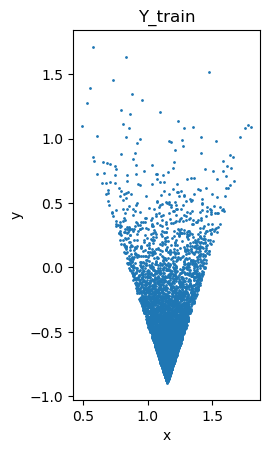

In [4]:
seed_everything(42)

n_train = 5000
n_test = 1000
n_calibration = 1000

k = 2
d = 2
pert = "exponential"
covariance_matrix = np.array([[1., 0.5], [0.5, 1.]])
data_generator = dataGenerator(d, k, pert, covariance_matrix = covariance_matrix)
y_train, y_test, y_calibration = data_generator.generate_perturbation_train_calibration_test(n_train, n_test, n_calibration)

a = np.array([0.5, 0.5])
b = 1.5

mask = (y_train @ a) < b

theta = - np.pi/4
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
y_train = y_train @ covariance_matrix @ rotation_matrix


y_train2 = y_train[mask]/1.6 + np.array([1.15, -0.9])
y_train2 = y_train/4 + np.array([1.15, -0.9])
y_test2 = y_train2
y_calibration2 = y_train2


# Plot the points
plt.scatter(y_train2[:, 0], y_train2[:, 1], s=1)
plt.title(f'Y_train')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

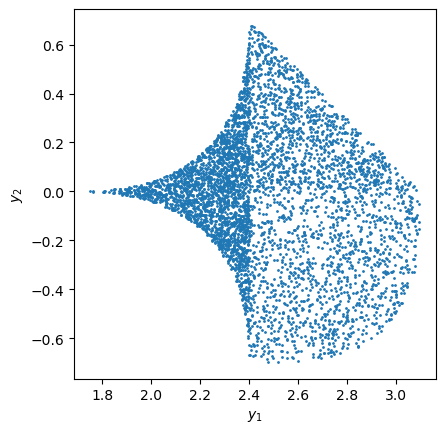

In [5]:
seed_everything(42)

n_train = 5000
n_test = 1000
n_calibration = 1000

p_left = 0.5
y_train_left, y_test_left, y_calibration_left = generate_uniform_points_in_p_norm_ball(n_train, p_left), generate_uniform_points_in_p_norm_ball(n_test, p_left), generate_uniform_points_in_p_norm_ball(n_calibration, p_left)

train_left_selected, test_left_selected, calibration_left_selected = y_train_left[y_train_left[:, 0] < 0], y_test_left[y_test_left[:, 0] < 0], y_calibration_left[y_calibration_left[:, 0] < 0]

p_right = 3
y_train_right, y_test_right, y_calibration_right = generate_uniform_points_in_p_norm_ball(n_train, p_right), generate_uniform_points_in_p_norm_ball(n_test, p_right), generate_uniform_points_in_p_norm_ball(n_calibration, p_right)

p_top_right = 1
y_train_top_right, y_test_top_right, y_calibration_top_right = generate_uniform_points_in_p_norm_ball(n_train, p_top_right), generate_uniform_points_in_p_norm_ball(n_test, p_top_right), generate_uniform_points_in_p_norm_ball(n_calibration, p_top_right)

train_right_selected = y_train_right[(y_train_right[:, 0] > 0) & (y_train_right[:, 1] < 0)]
test_right_selected = y_test_right[(y_test_right[:, 0] > 0) & (y_test_right[:, 1] < 0)]
calibration_right_selected = y_calibration_right[(y_calibration_right[:, 0] > 0) & (y_calibration_right[:, 1] < 0)]

train_top_right_selected = y_train_top_right[(y_train_top_right[:, 0] >= 0) & (y_train_top_right[:, 1] > 0)]
test_top_right_selected = y_test_top_right[(y_test_top_right[:, 0] >= 0) & (y_test_top_right[:, 1] > 0)]
calibration_top_right_selected = y_calibration_top_right[(y_calibration_top_right[:, 0] >= 0) & (y_calibration_top_right[:, 1] > 0)]
                                                         
y_train3 = np.vstack((train_left_selected, train_right_selected, train_top_right_selected))*0.7 + np.array([2.4, 0.])
y_test3 = y_train3
y_calibration3 = y_train3


# Affichage des points
plt.scatter(y_train3[:, 0], y_train3[:, 1], s=1)
plt.xlabel(r'$y_1$')
plt.ylabel(r'$y_2$')
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



(-1.2, 1.18)

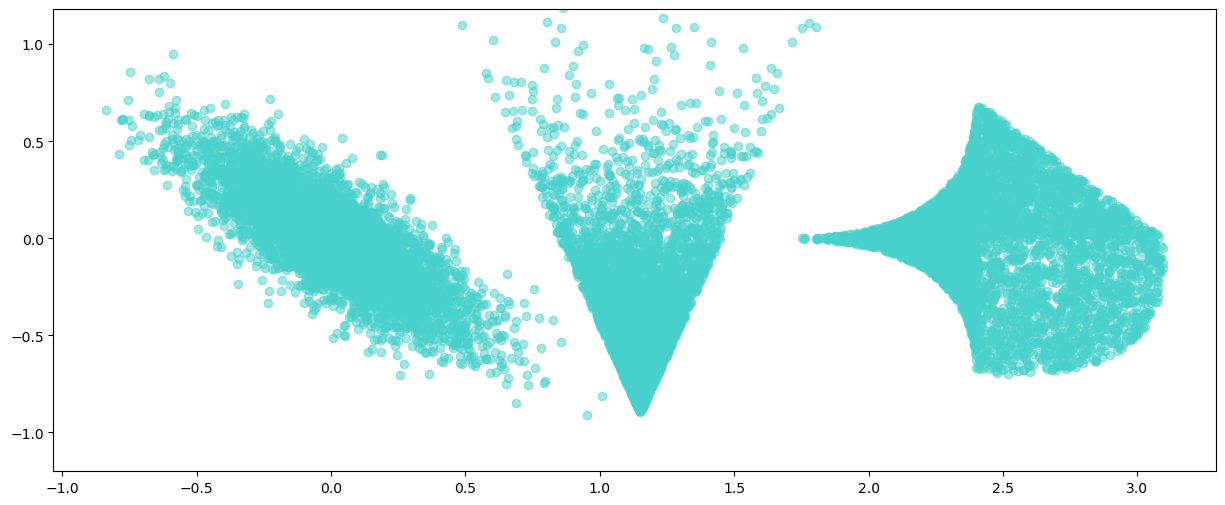

In [6]:
plt.figure(figsize=(15, 6))
plt.scatter(*y_train1.T, c='mediumturquoise', alpha=0.5)
plt.scatter(*y_train2.T, c='mediumturquoise', alpha=0.5)
plt.scatter(*y_train3.T, c='mediumturquoise', alpha=0.5)
plt.ylim(-1.2, 1.18)



In [7]:
seed_everything(42)

alpha1 = 0.05


seed_everything(38)

ellipsoid_predictor1 = EllipsoidPredictor()
ellipsoid_predictor1.fit(y_train1, alpha1)
ellipsoid_predictor1.conformalize(y_calibration1, alpha1)

print("ellipsoid_predictor volume : ", ellipsoid_predictor1.get_volume())

Network with  1 hidden layers and a hidden dimension of  128
ellipsoid_predictor volume :  0.7205580004787729


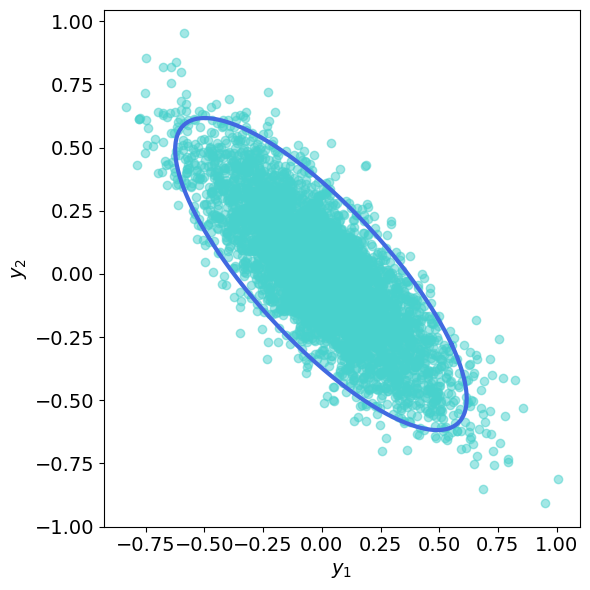

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(*y_train1.T, c='mediumturquoise', alpha=0.5)
ax = add_ellipse(ax, ellipsoid_predictor1.mu, ellipsoid_predictor1.Lambda, ellipsoid_predictor1.q, ellipsoid_predictor1.nu, color = "royalblue", label = f"Single-norm MVCS")

# ax.grid(True)
ax.legend().remove()
# ax.legend(fontsize=14)

ax.set_xlabel(r'$y_1$', fontsize=14)
ax.set_ylabel(r'$y_2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout() 

# Display the plot
plt.show()
plt.close()


In [9]:

seed_everything(42)

ellipsoid_predictor2 = EllipsoidPredictor()
ellipsoid_predictor2.fit(y_train2, alpha1)
ellipsoid_predictor2.conformalize(y_calibration2, alpha1)

print("ellipsoid_predictor volume : ", ellipsoid_predictor2.get_volume())

Network with  1 hidden layers and a hidden dimension of  128
ellipsoid_predictor volume :  0.6430147396756251


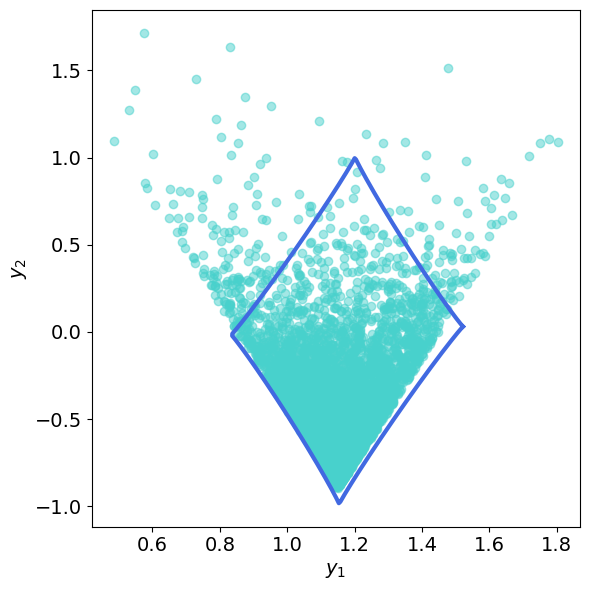

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(*y_train2.T, c='mediumturquoise', alpha=0.5)
ax = add_ellipse(ax, ellipsoid_predictor2.mu, ellipsoid_predictor2.Lambda, ellipsoid_predictor2.q, ellipsoid_predictor2.nu, color = "royalblue", label = f"Single-norm MVCS")

# ax.grid(True)
ax.legend().remove()
# ax.legend(fontsize=14)

ax.set_xlabel(r'$y_1$', fontsize=14)
ax.set_ylabel(r'$y_2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout() 

# Display the plot
plt.show()
plt.close()


In [11]:
seed_everything(1)

# k = 2
# d = 2


# ellipsoid_predictor3 = EllipsoidPredictor()
# ellipsoid_predictor3.fit(y_train3, alpha1, num_epochs_our_loss = 3000)
# ellipsoid_predictor3.conformalize(y_calibration3, alpha1)

n_splits = 2

half_ellipsoid_predictor3 = HalfEllipsoidPredictor(n_splits)
half_ellipsoid_predictor3.fit(y_train3, alpha1, verbose=0)
half_ellipsoid_predictor3.conformalize_ellipsoids(y_calibration3, alpha1)

# print("ellipsoid_predictor volume : ", ellipsoid_predictor3.get_volume())
print("half_ellipsoid_predictor volume : ", half_ellipsoid_predictor3.get_volume())

Network with  1 hidden layers and a hidden dimension of  5


/Users/sbraun/Desktop/Inria/MVCS/experiments/one_matrix_MVCS/code/half_ellipsoid_predictor.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, dtype=torch.float32)  # Ensure points are float tensors


half_ellipsoid_predictor volume :  0.7726818184899356


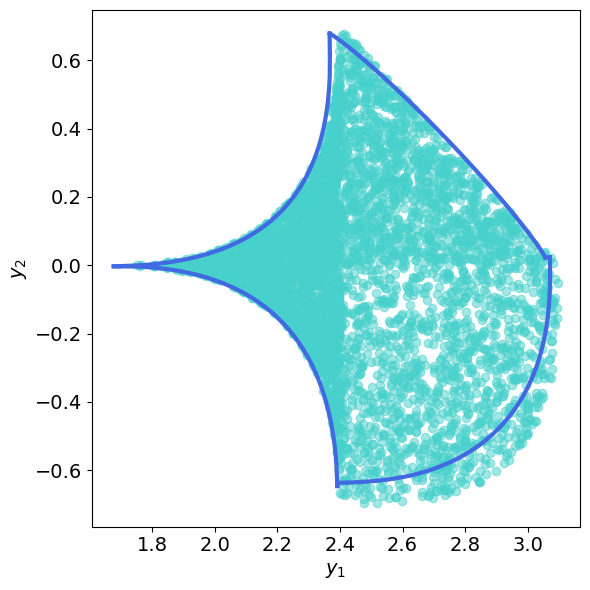

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))


ax.scatter(*y_train3.T, c='mediumturquoise', alpha=0.5)
# ax = add_ellipse(ax, ellipsoid_predictor3.mu, ellipsoid_predictor3.Lambda, ellipsoid_predictor3.q, ellipsoid_predictor3.nu, color = "royalblue", label = f"Single-norm MVCS")

ax = add_ellipse_multiple_lambdas(ax, 
                              half_ellipsoid_predictor3.mu, 
                              half_ellipsoid_predictor3.rotationMatrix, 
                              half_ellipsoid_predictor3.tab_diag,
                              half_ellipsoid_predictor3.tab_q, 
                              half_ellipsoid_predictor3.split, 
                              half_ellipsoid_predictor3.nu, color = "royalblue", label='Multi-norm MVCS')

# ax.grid(True)
ax.legend().remove()
# ax.legend(fontsize=14)

ax.set_xlabel(r'$y_1$', fontsize=14)
ax.set_ylabel(r'$y_2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout() 

# plt.savefig(f"../figs/intro_plot.pdf", dpi=300, bbox_inches='tight')
# Display the plot
plt.show()
plt.close()


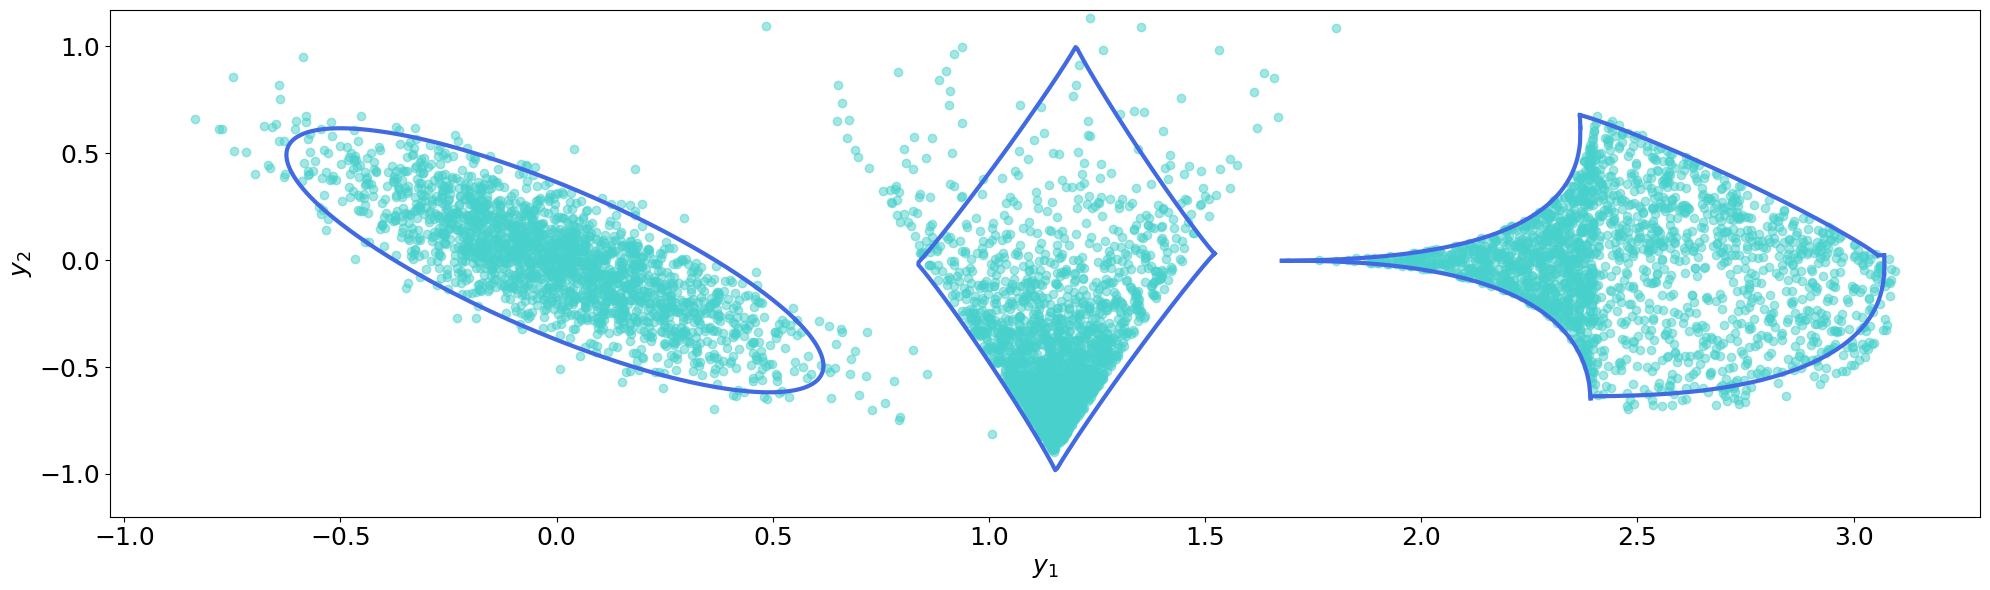

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))

idx = np.random.choice(np.arange(len(y_train3)), 2000, replace=False)

ax.scatter(*y_train1[idx].T, c='mediumturquoise', alpha=0.5)
# ax = add_ellipse_multiple_lambdas(ax, 
#                               half_ellipsoid_predictor1.mu, 
#                               half_ellipsoid_predictor1.rotationMatrix, 
#                               half_ellipsoid_predictor1.tab_diag,
#                               half_ellipsoid_predictor1.tab_q, 
#                               half_ellipsoid_predictor1.split, 
#                               half_ellipsoid_predictor1.nu, color = "royalblue", label='Multi-norm MVCS')

ax = add_ellipse(ax, ellipsoid_predictor1.mu, ellipsoid_predictor1.Lambda, ellipsoid_predictor1.q, ellipsoid_predictor1.nu, color = "royalblue", label = f"Single-norm MVCS")

ax.scatter(*y_train2[idx].T, c='mediumturquoise', alpha=0.5)
ax = add_ellipse(ax, ellipsoid_predictor2.mu, ellipsoid_predictor2.Lambda, ellipsoid_predictor2.q, ellipsoid_predictor2.nu, color = "royalblue", label = f"Single-norm MVCS")

ax.scatter(*y_train3[idx].T, c='mediumturquoise', alpha=0.5)
# ax = add_ellipse(ax, ellipsoid_predictor3.mu, ellipsoid_predictor3.Lambda, ellipsoid_predictor3.q, ellipsoid_predictor3.nu, color = "royalblue", label = f"Single-norm MVCS")
ax = add_ellipse_multiple_lambdas(ax, 
                              half_ellipsoid_predictor3.mu, 
                              half_ellipsoid_predictor3.rotationMatrix, 
                              half_ellipsoid_predictor3.tab_diag,
                              half_ellipsoid_predictor3.tab_q, 
                              half_ellipsoid_predictor3.split, 
                              half_ellipsoid_predictor3.nu, color = "royalblue", label='Multi-norm MVCS')


# ax.grid(True)
ax.legend().remove()
# ax.legend(fontsize=14)
plt.ylim(-1.2, 1.17)
ax.set_xlabel(r'$y_1$', fontsize=18)
ax.set_ylabel(r'$y_2$', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fig.tight_layout() 

plt.savefig(f"../figs/intro_plot_q1_{ellipsoid_predictor1.q}_q2_{ellipsoid_predictor2.q}_q3_{half_ellipsoid_predictor3.tab_q}.pdf", dpi=300, bbox_inches='tight')
# Display the plot
plt.show()
plt.close()
